In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("sonia22222/students-mental-health-assessments")
print("Path to dataset files:", path)
dataset_files = [file for file in os.listdir(path) if file.endswith(".csv")]

# Load the first CSV file found into a Pandas DataFrame
if dataset_files:
    main_dataset_file = os.path.join(path, dataset_files[0])
    df = pd.read_csv(main_dataset_file)
    print("Main dataset loaded successfully into DataFrame.")
else:
    print("No CSV files found in the dataset path.")

# Display the first few rows of the DataFrame to confirm loading
print(df.head())

# Exploratory Data Analysis

# 1. Data Overview
print("\nData Overview:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe(include='all'))

# 2. Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Data Visualization

# Histograms for numerical features
# numerical_features = df.select_dtypes(include=['number'])
# for col in numerical_features.columns:
#     plt.figure(figsize=(8, 6))
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()


# # Box plots for numerical features to identify outliers
# for col in numerical_features.columns:
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(y=df[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()

# # Count plots for categorical features
# categorical_features = df.select_dtypes(include=['object'])
# for col in categorical_features.columns:
#     plt.figure(figsize=(10, 6))
#     sns.countplot(x=df[col])
#     plt.title(f'Counts of {col}')
#     plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
#     plt.show()


100%|██████████| 101k/101k [00:00<00:00, 15.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sonia22222/students-mental-health-assessments/versions/4
Main dataset loaded successfully into DataFrame.
   Age            Course  Gender  CGPA  Stress_Level  Depression_Score  \
0   25            Others    Male  3.56             3                 3   
1   24       Engineering  Female  2.44             0                 3   
2   19          Business  Female  3.74             4                 0   
3   19  Computer Science    Male  3.65             2                 1   
4   18          Business    Male  3.40             3                 3   

   Anxiety_Score Sleep_Quality Physical_Activity Diet_Quality Social_Support  \
0              2          Good          Moderate         Good       Moderate   
1              0       Average               Low      Average            Low   
2              3          Good               Low      Average       Moderate   
3              0       Average               Low      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          7022 non-null   int64  
 1   Course                       7022 non-null   object 
 2   Gender                       7022 non-null   object 
 3   CGPA                         7010 non-null   float64
 4   Stress_Level                 7022 non-null   int64  
 5   Depression_Score             7022 non-null   int64  
 6   Anxiety_Score                7022 non-null   int64  
 7   Sleep_Quality                7022 non-null   object 
 8   Physical_Activity            7022 non-null   object 
 9   Diet_Quality                 7022 non-null   object 
 10  Social_Support               7022 non-null   object 
 11  Relationship_Status          7022 non-null   object 
 12  Substance_Use                7007 non-null   object 
 13  Counseling_Service

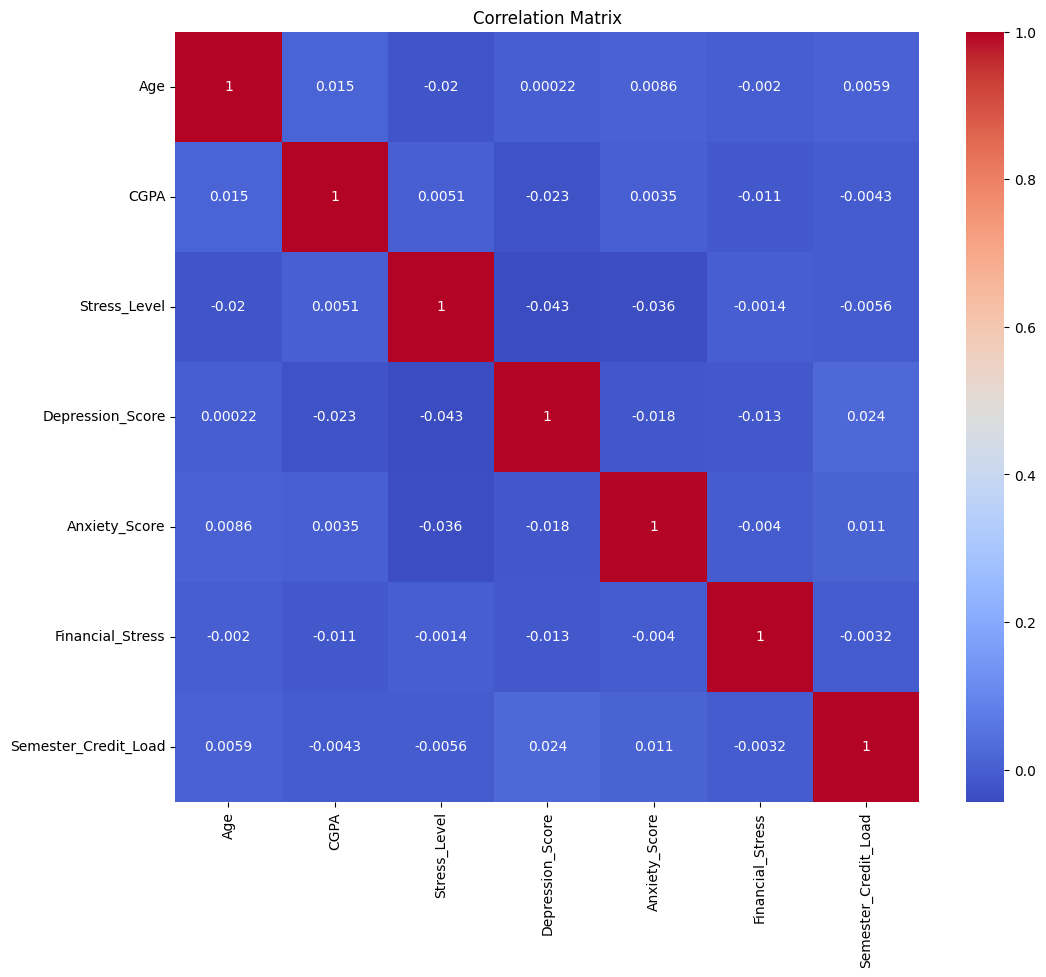

In [2]:
# Correlation matrix (for numerical features)
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')  # Select only numerical features
plt.title('Correlation Matrix')
plt.show()

# 4. Data Cleaning (Example: Handling Missing Values - replace with appropriate strategy)
# for col in numerical_features.columns:
#     if df[col].isnull().any():
#         df[col].fillna(df[col].mean(), inplace=True)
# print(df.isnull().sum())


In [3]:
df.columns

Index(['Age', 'Course', 'Gender', 'CGPA', 'Stress_Level', 'Depression_Score',
       'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality',
       'Social_Support', 'Relationship_Status', 'Substance_Use',
       'Counseling_Service_Use', 'Family_History', 'Chronic_Illness',
       'Financial_Stress', 'Extracurricular_Involvement',
       'Semester_Credit_Load', 'Residence_Type'],
      dtype='object')

In [4]:
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values)

# Remove rows with any missing values
df = df.dropna()

# Verify that there are no more missing values
print("\nMissing Values after removal:")
print(df.isnull().sum())



Missing Values:
Age                             0
Course                          0
Gender                          0
CGPA                           12
Stress_Level                    0
Depression_Score                0
Anxiety_Score                   0
Sleep_Quality                   0
Physical_Activity               0
Diet_Quality                    0
Social_Support                  0
Relationship_Status             0
Substance_Use                  15
Counseling_Service_Use          0
Family_History                  0
Chronic_Illness                 0
Financial_Stress                0
Extracurricular_Involvement     0
Semester_Credit_Load            0
Residence_Type                  0
dtype: int64

Missing Values after removal:
Age                            0
Course                         0
Gender                         0
CGPA                           0
Stress_Level                   0
Depression_Score               0
Anxiety_Score                  0
Sleep_Quality               

In [5]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [7]:
pip install scikeras



--- Logistic Regression ---
Fold 1:
  Accuracy: 0.63
  Precision: 0.65
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 1):
[[579 139]
 [375 306]]
------------------------------
Fold 2:
  Accuracy: 0.63
  Precision: 0.65
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 2):
[[602 117]
 [395 285]]
------------------------------
Fold 3:
  Accuracy: 0.60
  Precision: 0.62
  Recall: 0.60
  F1-Score: 0.59
  Confusion Matrix (Fold 3):
[[583 136]
 [417 263]]
------------------------------
Fold 4:
  Accuracy: 0.63
  Precision: 0.65
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 4):
[[589 130]
 [384 296]]
------------------------------
Fold 5:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 5):
[[573 146]
 [368 312]]
------------------------------
--- Aggregated Results for Logistic Regression ---
Accuracy: 0.63 ± 0.01
Precision: 0.64
Recall: 0.63
F1-Score: 0.61


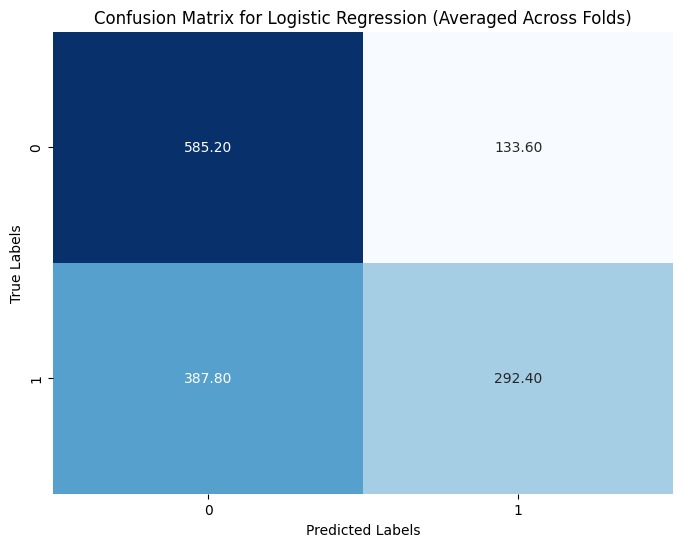


--- SVM ---
Fold 1:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 1):
[[568 150]
 [368 313]]
------------------------------
Fold 2:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.61
  Confusion Matrix (Fold 2):
[[585 134]
 [385 295]]
------------------------------
Fold 3:
  Accuracy: 0.60
  Precision: 0.61
  Recall: 0.60
  F1-Score: 0.58
  Confusion Matrix (Fold 3):
[[570 149]
 [412 268]]
------------------------------
Fold 4:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 4):
[[580 139]
 [377 303]]
------------------------------
Fold 5:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 5):
[[566 153]
 [370 310]]
------------------------------
--- Aggregated Results for SVM ---
Accuracy: 0.62 ± 0.01
Precision: 0.64
Recall: 0.62
F1-Score: 0.61


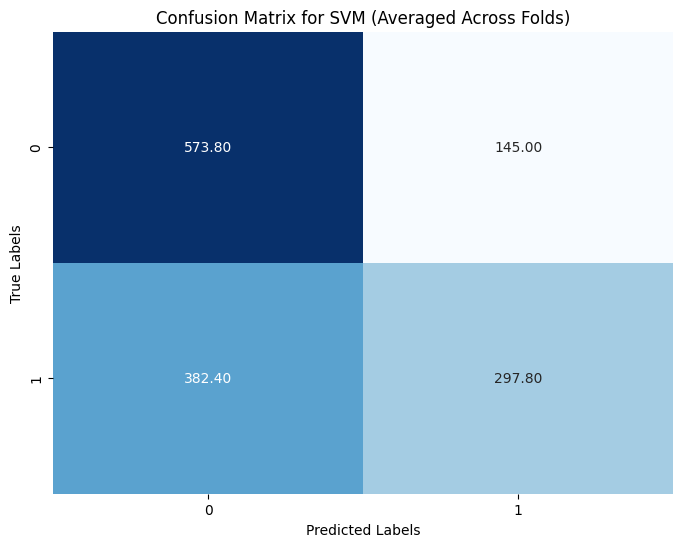


--- K-Nearest Neighbors ---
Fold 1:
  Accuracy: 0.52
  Precision: 0.52
  Recall: 0.52
  F1-Score: 0.52
  Confusion Matrix (Fold 1):
[[386 332]
 [334 347]]
------------------------------
Fold 2:
  Accuracy: 0.53
  Precision: 0.53
  Recall: 0.53
  F1-Score: 0.53
  Confusion Matrix (Fold 2):
[[396 323]
 [338 342]]
------------------------------
Fold 3:
  Accuracy: 0.54
  Precision: 0.54
  Recall: 0.54
  F1-Score: 0.54
  Confusion Matrix (Fold 3):
[[406 313]
 [326 354]]
------------------------------
Fold 4:
  Accuracy: 0.52
  Precision: 0.52
  Recall: 0.52
  F1-Score: 0.52
  Confusion Matrix (Fold 4):
[[386 333]
 [338 342]]
------------------------------
Fold 5:
  Accuracy: 0.53
  Precision: 0.53
  Recall: 0.53
  F1-Score: 0.53
  Confusion Matrix (Fold 5):
[[391 328]
 [326 354]]
------------------------------
--- Aggregated Results for K-Nearest Neighbors ---
Accuracy: 0.53 ± 0.01
Precision: 0.53
Recall: 0.53
F1-Score: 0.53


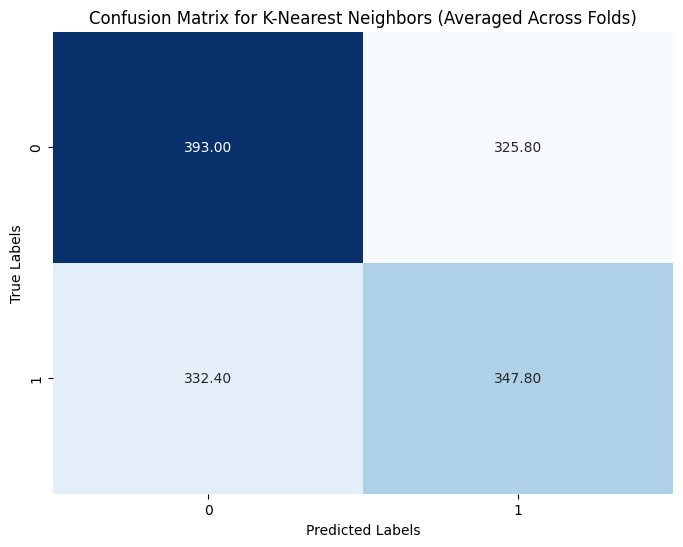


--- Random Forest ---
Fold 1:
  Accuracy: 0.61
  Precision: 0.62
  Recall: 0.61
  F1-Score: 0.61
  Confusion Matrix (Fold 1):
[[509 209]
 [330 351]]
------------------------------
Fold 2:
  Accuracy: 0.62
  Precision: 0.62
  Recall: 0.62
  F1-Score: 0.61
  Confusion Matrix (Fold 2):
[[531 188]
 [347 333]]
------------------------------
Fold 3:
  Accuracy: 0.59
  Precision: 0.59
  Recall: 0.59
  F1-Score: 0.58
  Confusion Matrix (Fold 3):
[[519 200]
 [373 307]]
------------------------------
Fold 4:
  Accuracy: 0.60
  Precision: 0.60
  Recall: 0.60
  F1-Score: 0.59
  Confusion Matrix (Fold 4):
[[508 211]
 [351 329]]
------------------------------
Fold 5:
  Accuracy: 0.60
  Precision: 0.61
  Recall: 0.60
  F1-Score: 0.60
  Confusion Matrix (Fold 5):
[[505 214]
 [339 341]]
------------------------------
--- Aggregated Results for Random Forest ---
Accuracy: 0.61 ± 0.01
Precision: 0.61
Recall: 0.61
F1-Score: 0.60


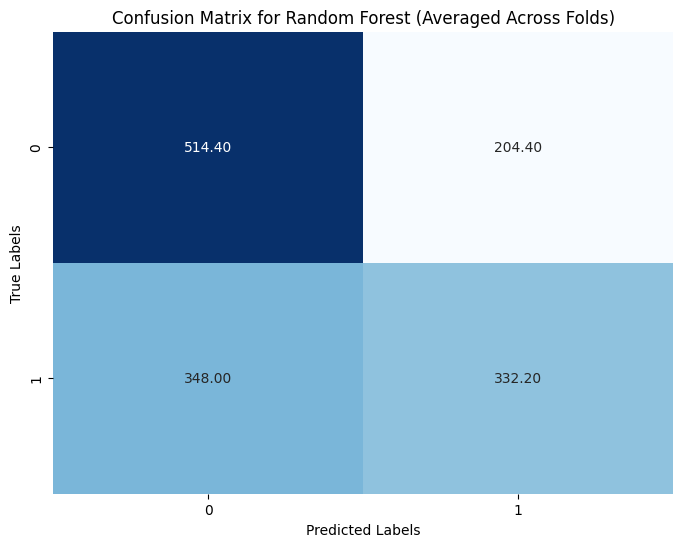


--- Gradient Boosting ---
Fold 1:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 1):
[[562 156]
 [364 317]]
------------------------------
Fold 2:
  Accuracy: 0.63
  Precision: 0.65
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 2):
[[585 134]
 [381 299]]
------------------------------
Fold 3:
  Accuracy: 0.60
  Precision: 0.60
  Recall: 0.60
  F1-Score: 0.58
  Confusion Matrix (Fold 3):
[[551 168]
 [396 284]]
------------------------------
Fold 4:
  Accuracy: 0.63
  Precision: 0.64
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 4):
[[564 155]
 [366 314]]
------------------------------
Fold 5:
  Accuracy: 0.63
  Precision: 0.63
  Recall: 0.63
  F1-Score: 0.62
  Confusion Matrix (Fold 5):
[[557 162]
 [360 320]]
------------------------------
--- Aggregated Results for Gradient Boosting ---
Accuracy: 0.62 ± 0.01
Precision: 0.63
Recall: 0.62
F1-Score: 0.61


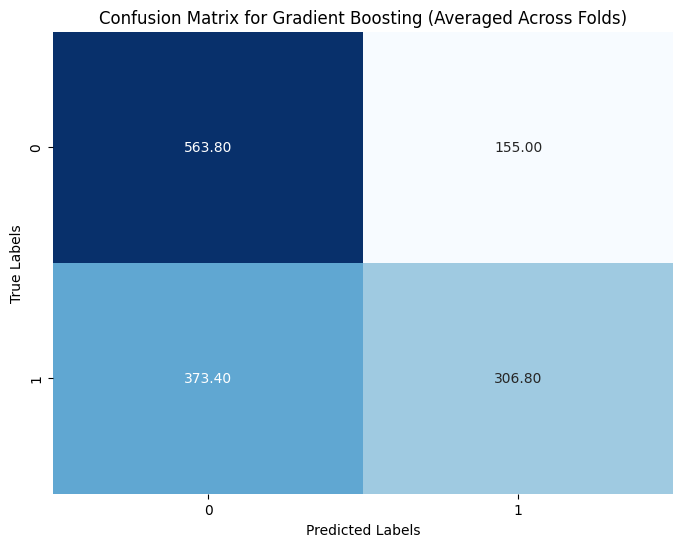


--- AdaBoost ---


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from scikeras.wrappers import KerasClassifier  # Updated import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from lightgbm import LGBMClassifier

# Ensure you have scikeras installed
# You can install it via pip if you haven't:
# !pip install scikeras

# Assuming 'df' is your DataFrame and it's already loaded
# Example:
# df = pd.read_csv('your_data.csv')

# Feature Selection
features = [
    'Age', 'Course', 'Gender', 'CGPA', 'Sleep_Quality',
    'Physical_Activity', 'Diet_Quality', 'Social_Support',
    'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use',
    'Family_History', 'Chronic_Illness', 'Financial_Stress',
    'Extracurricular_Involvement', 'Semester_Credit_Load',
    'Residence_Type'
]

X = df[features]
y = df['Stress_Level']

# One-hot encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Encoding and binning the target variable
y = y.apply(lambda x: 0 if x <= 2 else 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Function to create a simple feedforward neural network
def create_ffnn(input_shape, **kwargs):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define pipelines with model-specific preprocessing
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('pca', PCA(n_components=0.95)),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'SVM': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('pca', PCA(n_components=0.95)),
        ('classifier', SVC())
    ]),
    'K-Nearest Neighbors': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', KNeighborsClassifier())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', RandomForestClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', GradientBoostingClassifier())
    ]),
    'AdaBoost': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', AdaBoostClassifier())
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', LGBMClassifier())
    ]),
}

# Parameters for tuning (can be extended for hyperparameter optimization)
parameters = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10]},
    'SVM': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']},
    'K-Nearest Neighbors': {'classifier__n_neighbors': [3, 5, 7]},
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'AdaBoost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1]
}}

# Define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Results storage
cv_results = {}

for name, pipeline in pipelines.items():
    print(f"\n--- {name} ---")

    fold_conf_matrices = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Iterate through each fold
    for fold, (train_index, test_index) in enumerate(cv.split(X, y), start=1):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        try:
            # Fit and predict for the current fold
            pipeline.fit(X_train_fold, y_train_fold)
            y_pred_fold = pipeline.predict(X_test_fold)
        except Exception as e:
            print(f"Error in fold {fold}: {e}")
            continue

        # Metrics
        acc = accuracy_score(y_test_fold, y_pred_fold)
        report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
        prec = report['weighted avg']['precision']
        rec = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        accuracy_scores.append(acc)
        precision_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        fold_conf_matrices.append(conf_matrix)

        # Print metrics for the current fold
        print(f"Fold {fold}:")
        print(f"  Accuracy: {acc:.2f}")
        print(f"  Precision: {prec:.2f}")
        print(f"  Recall: {rec:.2f}")
        print(f"  F1-Score: {f1:.2f}")
        print(f"  Confusion Matrix (Fold {fold}):")
        print(conf_matrix)
        print("-" * 30)

    # Aggregate results across folds
    cv_results[name] = {
        'accuracy_mean': np.mean(accuracy_scores),
        'accuracy_std': np.std(accuracy_scores),
        'precision_mean': np.mean(precision_scores),
        'recall_mean': np.mean(recall_scores),
        'f1_mean': np.mean(f1_scores)
    }

    # Print aggregated results
    print(f"--- Aggregated Results for {name} ---")
    print(f"Accuracy: {cv_results[name]['accuracy_mean']:.2f} ± {cv_results[name]['accuracy_std']:.2f}")
    print(f"Precision: {cv_results[name]['precision_mean']:.2f}")
    print(f"Recall: {cv_results[name]['recall_mean']:.2f}")
    print(f"F1-Score: {cv_results[name]['f1_mean']:.2f}")

    # Plot the averaged confusion matrix
    if fold_conf_matrices:
        avg_conf_matrix = np.mean(fold_conf_matrices, axis=0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {name} (Averaged Across Folds)')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

# Display overall summary table
results_df = pd.DataFrame(cv_results).T
results_df = results_df.sort_values(by='accuracy_mean', ascending=False)

# Display the table
print("\n--- Overall Cross-Validation Results ---")
print(results_df)